In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

- The text of a tweet
- A keyword from that tweet (although this may be blank!)
- The location the tweet was sent from (may also be blank)

## What am I predicting?

- You are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

## Columns
- id - a unique identifier for each tweet
- text - the text of the tweet
- location - the location the tweet was sent from (may be blank)
- keyword - a particular keyword from the tweet (may be blank)
- target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [2]:
train = pd.read_csv('NLP_disaster/train.csv')
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
test = pd.read_csv('NLP_disaster/test.csv')
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [4]:
submission = pd.read_csv('NLP_disaster/sample_submission.csv')
submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [5]:
pd.set_option('display.width', None)
print(train)

         id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near La Ronge Sask. Canada       1  
2     All residents asked to 'shelter in place' are ...       1  
3     13,000 people receive #wildfires evacuation or...       1  
4     Just got sent this photo from Ruby #Alaska as ...       1  
...                                                 ...     ...  
7608  Two giant cranes holding a bridge collapse int...       1  
7609  @aria_ahrary @TheTawniest The out of control w...       1  
7610  M1.94 [01:04 UT

# Simple example

In [6]:
simple_train = ['call you tonight', 'Call me a cab', 'Please call me... PLEASE!']

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

In [8]:
vect.fit(simple_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [9]:
vect.get_feature_names()

['cab', 'call', 'me', 'please', 'tonight', 'you']

1. 문서 단어 행렬(Document-Term Matrix, DTM)의 표기법
- 문서 단어 행렬(Document-Term Matrix, DTM)이란 다수의 문서에서 등장하는 각 단어들의 빈도를 행렬로 표현한 것을 말합니다. 쉽게 생각하면 각 문서에 대한 BoW를 하나의 행렬로 만든 것으로 생각할 수 있으며, BoW와 다른 표현 방법이 아니라 BoW 표현을 다수의 문서에 대해서 행렬로 표현하고 부르는 용어입니다. 예를 들어서 이렇게 4개의 문서가 있다고 합시다.

In [10]:
# transform training data into a 'document-term matrix'
simple_train_dtm = vect.transform(simple_train)
simple_train_dtm

<3x6 sparse matrix of type '<class 'numpy.int64'>'
	with 9 stored elements in Compressed Sparse Row format>

In [11]:
simple_train_dtm.toarray()

array([[0, 1, 0, 0, 1, 1],
       [1, 1, 1, 0, 0, 0],
       [0, 1, 1, 2, 0, 0]], dtype=int64)

In [12]:
example = pd.DataFrame(simple_train_dtm.toarray(), columns=vect.get_feature_names())
example

,cab,call,me,please,tonight,you
0,0,1,0,0,1,1
1,1,1,1,0,0,0
2,0,1,1,2,0,0


In [13]:
# example text for model testing
simple_test = ["please don't call me"]

simple_test_dtm = vect.transform(simple_test)
simple_test_dtm.toarray()

array([[0, 1, 1, 1, 0, 0]], dtype=int64)

In [14]:
pd.DataFrame(simple_test_dtm.toarray(), columns=vect.get_feature_names())

,cab,call,me,please,tonight,you
0,0,1,1,1,0,0


- vect.fit(열차)는 훈련 데이터의 어휘를 학습한다.

- vect.usage(열차)는 적합한 어휘를 사용하여 교육 데이터로부터 문서 용어 매트릭스를 작성한다.

- vect.properties(test)는 적합 어휘를 사용하여 테스트 데이터로부터 문서 용어 매트릭스를 작성한다(그리고 이전에 보지 못한 토큰은 무시함).

# 1. Data

In [15]:
train.dropna(how="any", inplace=True, axis=1)

train.columns = ['id', 'message', 'label']
train.head()

,id,message,label
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


# 2. Exploratory Data Analysis (EDA)

In [16]:
train.describe()

,id,label
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [17]:
train.groupby('label').describe()

id                                                           \
        count         mean          std   min      25%     50%     75%   
label                                                                    
0      4342.0  5276.446338  3157.206802  23.0  2513.25  5243.5  8038.5   
1      3271.0  5661.608071  3097.094809   1.0  3104.50  5676.0  8252.0   

                
           max  
label           
0      10848.0  
1      10873.0

In [18]:
train['message_len'] = train.message.apply(len)
train

,id,message,label,message_len
0,1,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,Forest fire near La Ronge Sask. Canada,1,38
2,5,All residents asked to 'shelter in place' are ...,1,133
3,6,"13,000 people receive #wildfires evacuation or...",1,65
4,7,Just got sent this photo from Ruby #Alaska as ...,1,88
...,...,...,...,...
7608,10869,Two giant cranes holding a bridge collapse int...,1,83
7609,10870,@aria_ahrary @TheTawniest The out of control w...,1,125
7610,10871,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,65
7611,10872,Police investigating after an e-bike collided ...,1,137


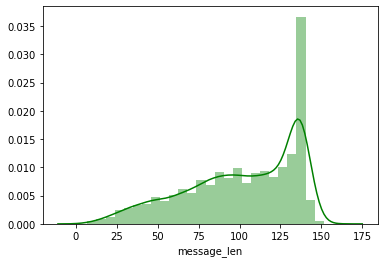

In [19]:
sns.distplot(train['message_len'], color="green")

In [20]:
train[train['label'] == 1].describe()

,id,label,message_len
count,3271.000000,3271.0,3271.000000
mean,5661.608071,1.0,108.113421
std,3097.094809,0.0,29.309854
min,1.000000,1.0,14.000000
25%,3104.500000,1.0,88.000000
50%,5676.000000,1.0,115.000000
75%,8252.000000,1.0,136.000000
max,10873.000000,1.0,151.000000


In [21]:
train[train['label'] == 0].describe()

,id,label,message_len
count,4342.000000,4342.0,4342.000000
mean,5276.446338,0.0,95.706817
std,3157.206802,0.0,35.885924
min,23.000000,0.0,7.000000
25%,2513.250000,0.0,68.000000
50%,5243.500000,0.0,101.000000
75%,8038.500000,0.0,130.000000
max,10848.000000,0.0,157.000000


In [22]:
# True Max
train[train['message_len'] == 151]['message']

614    @CAgov If 90BLKs&amp;8WHTs colluded 2 take WHT...
Name: message, dtype: object

In [23]:
train[train['message_len'] == 157]['message']

1270    when you're taking a shower and someone flushe...
Name: message, dtype: object

#  3. Text Pre-processing

## NLTK 라이브러리를 활용 -> 
1. 구두점 제거
2. stopword 제거
3. 정리된 clean text 반환

In [24]:
import string
from nltk.corpus import stopwords

In [25]:
def text_process(texts) :
    STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure', '','Û','Ò']
    
    punc = [char for char in texts if char not in string.punctuation]
    
    punc = ''.join(punc)
    
    return ' '.join(
        [word for word in punc.split() if word.lower() not in STOPWORDS])

In [26]:
train['clean'] = train['message'].apply(text_process)
train

,id,message,label,message_len,clean
0,1,Our Deeds are the Reason of this #earthquake M...,1,69,Deeds Reason earthquake May ALLAH Forgive us
1,4,Forest fire near La Ronge Sask. Canada,1,38,Forest fire near La Ronge Sask Canada
2,5,All residents asked to 'shelter in place' are ...,1,133,residents asked shelter place notified officer...
3,6,"13,000 people receive #wildfires evacuation or...",1,65,13000 people receive wildfires evacuation orde...
4,7,Just got sent this photo from Ruby #Alaska as ...,1,88,got sent photo Ruby Alaska smoke wildfires pou...
...,...,...,...,...,...
7608,10869,Two giant cranes holding a bridge collapse int...,1,83,Two giant cranes holding bridge collapse nearb...
7609,10870,@aria_ahrary @TheTawniest The out of control w...,1,125,ariaahrary TheTawniest control wild fires Cali...
7610,10871,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,65,M194 0104 UTC5km Volcano Hawaii httptcozDtoyd8EbJ
7611,10872,Police investigating after an e-bike collided ...,1,137,Police investigating ebike collided car Little...


In [27]:
train[train['message_len'] == 157]['clean'] 
#제대로 clean 되었음

1270    youre taking shower someone flushes toilet 1 s...
Name: clean, dtype: object

In [28]:
from collections import Counter

words = train[train.label== 1]['clean'].apply(lambda x: [word.lower() for word in x.split()])
disaster_words = Counter()

for msg in words:
    disaster_words.update(msg)
    
print(disaster_words.most_common(50))

[('fire', 178), ('news', 136), ('via', 121), ('disaster', 117), ('california', 111), ('suicide', 110), ('police', 107), ('amp', 106), ('people', 105), ('killed', 93), ('like', 92), ('hiroshima', 86), ('storm', 85), ('crash', 84), ('fires', 84), ('us', 81), ('families', 81), ('train', 79), ('emergency', 76), ('buildings', 75), ('bomb', 74), ('two', 71), ('mh370', 71), ('nuclear', 70), ('attack', 69), ('video', 69), ('wildfire', 69), ('get', 66), ('accident', 66), ('bombing', 66), ('one', 65), ('northern', 64), ('burning', 64), ('dead', 63), ('pm', 62), ('legionnaires', 62), ('bomber', 60), ('homes', 58), ('car', 57), ('still', 57), ('war', 57), ('new', 56), ('atomic', 56), ('obama', 54), ('fatal', 54), ('years', 53), ('collapse', 51), ('may', 50), ('forest', 50), ('debris', 50)]


In [29]:
words = train[train.label== 0]['clean'].apply(lambda x: [word.lower() for word in x.split()])
non_disaster_words = Counter()

for msg in words:
    non_disaster_words.update(msg)
    
print(non_disaster_words.most_common(50))

[('like', 253), ('amp', 192), ('new', 168), ('get', 163), ('one', 128), ('body', 112), ('via', 99), ('would', 97), ('video', 96), ('people', 91), ('love', 89), ('know', 85), ('back', 84), ('time', 83), ('us', 83), ('got', 83), ('see', 82), ('cant', 81), ('emergency', 81), ('full', 81), ('day', 78), ('youtube', 76), ('going', 75), ('still', 72), ('fire', 72), ('go', 67), ('want', 67), ('good', 67), ('think', 66), ('3', 64), ('man', 62), ('world', 62), ('lol', 61), ('rt', 60), ('life', 60), ('youre', 58), ('first', 58), ('news', 57), ('last', 56), ('burning', 56), ('really', 55), ('way', 55), ('need', 55), ('make', 54), ('work', 54), ('best', 53), ('let', 52), ('much', 51), ('many', 51), ('even', 51)]


# 4. 단어 벡터화(Vectorization) - check frequency

In [30]:
X = train.clean
y = train.label
print(X.shape)
print(y.shape)

(7613,)
(7613,)


In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6090,)
(1523,)
(6090,)
(1523,)


In [32]:
# train 데이터 어휘 학습 후 문서 용어 매트릭스를 작성
X_train_dtm = vect.transform(X_train)
X_train_dtm

<6090x6 sparse matrix of type '<class 'numpy.int64'>'
	with 129 stored elements in Compressed Sparse Row format>

In [33]:
#동등하게 적합성과 변환을 한 단계로 결합
X_train_dtm = vect.fit_transform(X_train)
X_train_dtm

<6090x19076 sparse matrix of type '<class 'numpy.int64'>'
	with 58779 stored elements in Compressed Sparse Row format>

In [34]:
X_test_dtm = vect.transform(X_test)
X_test_dtm

<1523x19076 sparse matrix of type '<class 'numpy.int64'>'
	with 11274 stored elements in Compressed Sparse Row format>

## TF-IDF
- TF(단어 빈도, term frequency)는 특정한 단어가 문서 내에 얼마나 자주 등장하는지를 나타내는 값으로, 이 값이 높을수록 문서에서 중요하다고 생각할 수 있다. 하지만 단어 자체가 문서군 내에서 자주 사용되는 경우, 이것은 그 단어가 흔하게 등장한다는 것을 의미한다. 이것을 DF(문서 빈도, document frequency)라고 하며, 이 값의 역수를 IDF(역문서 빈도, inverse document frequency)라고 한다. TF-IDF는 TF와 IDF를 곱한 값이다.
- 
- IDF 값은 문서군의 성격에 따라 결정된다. 예를 들어 '원자'라는 낱말은 일반적인 문서들 사이에서는 잘 나오지 않기 때문에 IDF 값이 높아지고 문서의 핵심어가 될 수 있지만, 원자에 대한 문서를 모아놓은 문서군의 경우 이 낱말은 상투어가 되어 각 문서들을 세분화하여 구분할 수 있는 다른 낱말들이 높은 가중치를 얻게 된다.
- 
- 역문서 빈도(IDF)는 한 단어가 문서 집합 전체에서 얼마나 공통적으로 나타나는지를 나타내는 값이다. 전체 문서의 수를 해당 단어를 포함한 문서의 수로 나눈 뒤 로그를 취하여 얻을 수 있다.

In [105]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
a = tfidf_transformer.fit(X_train_dtm)
b = tfidf_transformer.transform(X_train_dtm)

In [106]:
a

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [107]:
b

<6090x19076 sparse matrix of type '<class 'numpy.float64'>'
	with 58779 stored elements in Compressed Sparse Row format>

In [71]:
tfidf_transformer

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

# 4. Modeling
### MultinomialNB 사용. MultinomialNB = Naive bayes 중 하나.
### 각 특성을 개별로 취급해 파라미터를 학습하고 각 특성에서 클래스별 통계를 단순하게 취합
### ( GaussianNB, BernoulliNB, MultinomialNB )
- GaussianNB : 연속형 데이터
- BernoulliNB : 이진형
- MultinomialNB : 카운트 데이터(특성이 어떤 것을 헤아린 정수 카운트

In [72]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [73]:
nb.fit(X_train_dtm, y_train) #%time 

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [74]:
y_pred = nb.predict(X_test_dtm)

In [75]:
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred)

0.7912015758371634

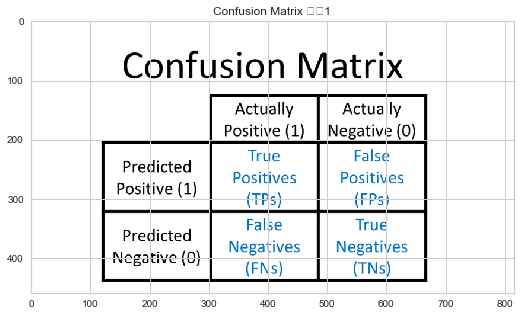

In [68]:
import tensorflow as tf
import matplotlib.pyplot as plt

file_path1 = tf.keras.utils.get_file('confusion_matrix.jpg', 
                                   'https://glassboxmedicine.files.wordpress.com/2019/02/confusion-matrix.png?w=816')

img = tf.io.read_file(file_path1)
img_tensor = tf.image.decode_image(img)

plt.figure(figsize=(10,5))
plt.title('Confusion Matrix 그림1')
plt.imshow(img_tensor)

In [76]:
matrix = metrics.confusion_matrix(y_test, y_pred)
matrix

array([[747, 114],
       [204, 458]], dtype=int64)

In [78]:
df_matrix = pd.DataFrame(columns = ['Actually Positive', 'Actually Negative'], index = ['Predicted Positive', 'Predicted Negative'])
df_matrix

,Actually Positive,Actually Negative
Predicted Positive,NaN,NaN
Predicted Negative,NaN,NaN


In [79]:
df_matrix['Actually Positive']['Predicted Positive'] = 747
df_matrix['Actually Positive']['Predicted Negative'] = 204
df_matrix['Actually Negative']['Predicted Positive'] = 114
df_matrix['Actually Negative']['Predicted Negative'] = 458
df_matrix

,Actually Positive,Actually Negative
Predicted Positive,747,114
Predicted Negative,204,458


In [80]:
# False prediction print
X_test[y_pred > y_test]

6587    Survivors Shanghai Ghetto reunite 70 years htt...
6338    CLIP Topdown coercion structural weakness ensu...
2293    Postal Service agrees sell demolish downtown b...
2116    VIDEO Slain Mexican Journalist Unknowingly Pre...
5080    team ready natural disaster violent client pow...
                              ...                        
7317    Man selling WILD MORELS Ambleside Farmr MartSu...
2811    DISASTER AVERTED Police kill gunman Û÷hoax de...
3740    Save Date Saturday August 15 2015 Salisbury Fi...
2111            New crime knowing rights Punishable death
5677    Summer summervibes california puppy pitmix res...
Name: clean, Length: 114, dtype: object

In [81]:
X_test[y_pred < y_test]

3119    babies actually get electrocuted wall sockets ...
4734    YoungHeroesID Lava Blast dan Power Red Panther...
6923               OH GOD RYANS TROUBLE httptcoADIp0UnXHU
775     anyone else see fireball falling earth Look li...
3321    want everyone know Emilee worried getting milk...
                              ...                        
2291    far right racist AvigdorLiberman calls destruc...
6154          real question tornado siren going Dyersburg
6047    MRW sinkhole opens beneath friends gif funny l...
1333    mv strutting like mean buildings burning bg fl...
3210    American family served military work emergency...
Name: clean, Length: 204, dtype: object

In [82]:
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

array([0.09216596, 0.11609247, 0.06097199, ..., 0.99795286, 0.99972831,
       0.00132731])

In [83]:
# calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob)

0.8478715117319494

In [84]:
#pip install yellowbrick

C:\Users\Playdata\anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


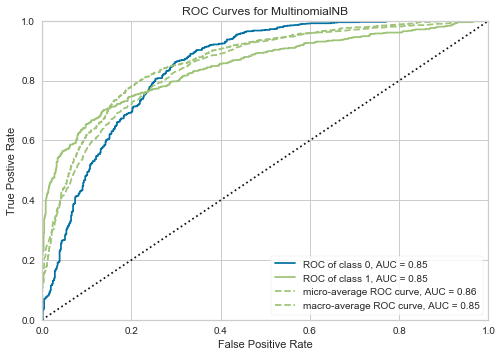

In [85]:
from yellowbrick.classifier import ROCAUC
from yellowbrick.datasets import load_spam

nbb = MultinomialNB()
nbb.fit(X_train_dtm, y_train)

visualizer = ROCAUC(nbb, classes=[0, 1])

visualizer.fit(X_train_dtm, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test_dtm, y_test)        # Evaluate the model on the test data
visualizer.show()         

# test

In [87]:
test

,id,message,message_len,clean
0,0,Just happened a terrible car crash,34,happened terrible car crash
1,2,"Heard about #earthquake is different cities, s...",64,Heard earthquake different cities stay safe ev...
2,3,"there is a forest fire at spot pond, geese are...",96,forest fire spot pond geese fleeing across str...
3,9,Apocalypse lighting. #Spokane #wildfires,40,Apocalypse lighting Spokane wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan,45,Typhoon Soudelor kills 28 China Taiwan
...,...,...,...,...
3258,10861,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,55,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,Storm in RI worse than last hurricane. My city...,139,Storm RI worse last hurricane cityamp3others h...
3260,10868,Green Line derailment in Chicago http://t.co/U...,55,Green Line derailment Chicago httptcoUtbXLcBIuY
3261,10874,MEG issues Hazardous Weather Outlook (HWO) htt...,65,MEG issues Hazardous Weather Outlook HWO httpt...


In [86]:
test.dropna(how="any", inplace=True, axis=1)
test.columns = ['id', 'message']
test.head()

ValueError: Length mismatch: Expected axis has 4 elements, new values have 2 elements

In [49]:
test['message_len'] = test.message.apply(len)
test

,id,message,message_len
0,0,Just happened a terrible car crash,34
1,2,"Heard about #earthquake is different cities, s...",64
2,3,"there is a forest fire at spot pond, geese are...",96
3,9,Apocalypse lighting. #Spokane #wildfires,40
4,11,Typhoon Soudelor kills 28 in China and Taiwan,45
...,...,...,...
3258,10861,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,55
3259,10865,Storm in RI worse than last hurricane. My city...,139
3260,10868,Green Line derailment in Chicago http://t.co/U...,55
3261,10874,MEG issues Hazardous Weather Outlook (HWO) htt...,65


In [50]:
test['clean'] = test['message'].apply(text_process)
test

,id,message,message_len,clean
0,0,Just happened a terrible car crash,34,happened terrible car crash
1,2,"Heard about #earthquake is different cities, s...",64,Heard earthquake different cities stay safe ev...
2,3,"there is a forest fire at spot pond, geese are...",96,forest fire spot pond geese fleeing across str...
3,9,Apocalypse lighting. #Spokane #wildfires,40,Apocalypse lighting Spokane wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan,45,Typhoon Soudelor kills 28 China Taiwan
...,...,...,...,...
3258,10861,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,55,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,Storm in RI worse than last hurricane. My city...,139,Storm RI worse last hurricane cityamp3others h...
3260,10868,Green Line derailment in Chicago http://t.co/U...,55,Green Line derailment Chicago httptcoUtbXLcBIuY
3261,10874,MEG issues Hazardous Weather Outlook (HWO) htt...,65,MEG issues Hazardous Weather Outlook HWO httpt...


In [88]:
test.describe()

,id,message_len
count,3263.000000,3263.000000
mean,5427.152927,102.108183
std,3146.427221,33.972158
min,0.000000,5.000000
25%,2683.000000,78.000000
50%,5500.000000,109.000000
75%,8176.000000,134.000000
max,10875.000000,151.000000


In [89]:
test[test['message_len'] == 151]['message']

279    @HarvardU If 90BLKs&amp;8WHTs colluded 2 take ...
283    @GACourts If 90BLKs&amp;8WHTs colluded 2 take ...
534    3 rules for a long life.  #1ÛÒDonÛªt go in b...
Name: message, dtype: object

In [90]:
test['clean'] = test['message'].apply(text_process)
test

,id,message,message_len,clean
0,0,Just happened a terrible car crash,34,happened terrible car crash
1,2,"Heard about #earthquake is different cities, s...",64,Heard earthquake different cities stay safe ev...
2,3,"there is a forest fire at spot pond, geese are...",96,forest fire spot pond geese fleeing across str...
3,9,Apocalypse lighting. #Spokane #wildfires,40,Apocalypse lighting Spokane wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan,45,Typhoon Soudelor kills 28 China Taiwan
...,...,...,...,...
3258,10861,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,55,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,Storm in RI worse than last hurricane. My city...,139,Storm RI worse last hurricane cityamp3others h...
3260,10868,Green Line derailment in Chicago http://t.co/U...,55,Green Line derailment Chicago httptcoUtbXLcBIuY
3261,10874,MEG issues Hazardous Weather Outlook (HWO) htt...,65,MEG issues Hazardous Weather Outlook HWO httpt...


In [91]:
test[test['message_len'] == 151]['clean']

279    HarvardU 90BLKsamp8WHTs colluded take WHT F US...
283    GACourts 90BLKsamp8WHTs colluded take WHT F US...
534    3 rules long life 1ÛÒDonÛªt go burning build...
Name: clean, dtype: object

In [92]:
test_dtm = vect.transform(test['clean'])
test_dtm

<3263x19076 sparse matrix of type '<class 'numpy.int64'>'
	with 24424 stored elements in Compressed Sparse Row format>

In [93]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(test_dtm)
tfidf_transformer.transform(test_dtm)

<3263x19076 sparse matrix of type '<class 'numpy.float64'>'
	with 24424 stored elements in Compressed Sparse Row format>

In [94]:
y_pred = nb.predict(test_dtm)

In [95]:
y_pred_prob = nb.predict_proba(test_dtm)[:, 1]
y_pred_prob

array([0.82479044, 0.74986114, 0.99538194, ..., 0.99066569, 0.99889834,
       0.99065561])

In [96]:
y_pred_prob.size

3263

# Submission

In [97]:
submission

,id,target
0,0,0.824790
1,2,0.749861
2,3,1.000000
3,9,1.000000
4,11,1.000000
...,...,...
3258,10861,1.000000
3259,10865,1.000000
3260,10868,1.000000
3261,10874,1.000000


In [98]:
y_pred_prob.size

3263

In [99]:
submission['target'] = y_pred_prob
submission

,id,target
0,0,0.824790
1,2,0.749861
2,3,0.995382
3,9,0.893315
4,11,0.999986
...,...,...
3258,10861,0.968913
3259,10865,0.902486
3260,10868,0.990666
3261,10874,0.998898


In [100]:
submission['target'] = submission['target'].apply(lambda x : 1 if x >= 0.5  else 0)

In [102]:
submission['target'].value_counts()

0    2061
1    1202
Name: target, dtype: int64

In [103]:
submission.to_csv('./sub2.csv', index=False)

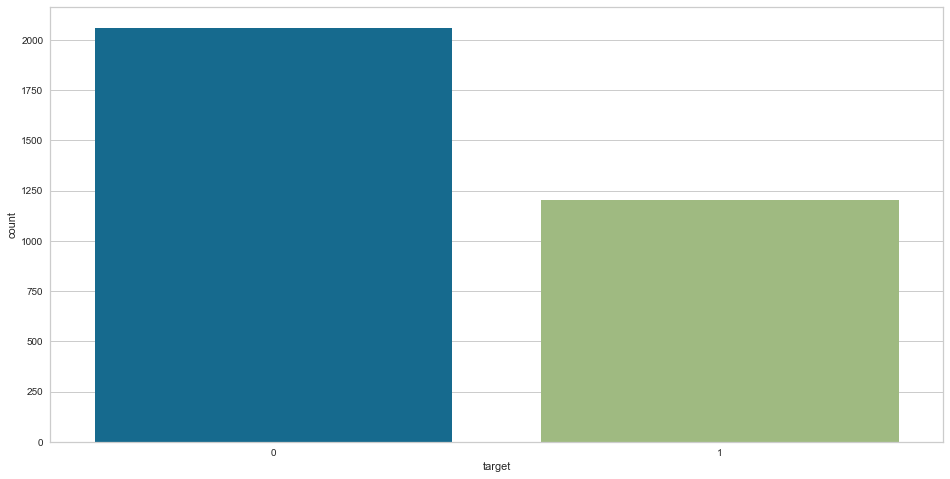

In [104]:
ttt = submission['target']
plt.figure(figsize=(16, 8))
sns.countplot(ttt)

In [63]:
submission['target'] = submission['target'].apply(lambda x : 1 if x >= 0.85 else x)

In [64]:
submission

,id,target
0,0,0.824790
1,2,0.749861
2,3,1.000000
3,9,1.000000
4,11,1.000000
...,...,...
3258,10861,1.000000
3259,10865,1.000000
3260,10868,1.000000
3261,10874,1.000000


In [65]:
#submission.to_csv('./sub1.csv', index=False)

In [66]:
s1 = pd.read_csv('sub1.csv')
s1

,id,target
0,0,0.824790
1,2,0.749861
2,3,1.000000
3,9,1.000000
4,11,1.000000
...,...,...
3258,10861,1.000000
3259,10865,1.000000
3260,10868,1.000000
3261,10874,1.000000
